In [1]:
import librosa
from ipywidgets import Audio
import IPython.display
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
import numpy as np
import scipy
import matplotlib.pyplot as plt
import soundfile as sf
import torch
from tqdm.notebook import tqdm
from functools import partial

from gfm_iaif import gfm_iaif
from utils import h1h2, weighted_log_mag_mse_loss
from tract_proxy import VocalTractProxy
from optimize import TractControlsOptimizer
from glottis import Glottis

# from dask.distributed import LocalCluster

Plan:


* Get glcoeffs vtcoefffs lpcoeffs
* Construct glsignal1 vtsignal1
* Construct excitation signal

* For GL and VL::::
    * Get roots 
    * Filter roots img > 0
    * Keep other roots
    * 
    * Compute freqz from phases
    * Distort phases to make new roots
    * Compute poly from new roots
    * 
    * Make sure coeffs start in one, normalize

* New signal = excitation * newGL * newVT

In [2]:
# input, fs = librosa.load("C#2.wav")
# Audio.from_file("C#2.wav", loop=False)
audio_input, fs = librosa.load("C2.wav")  #("0_47.wav")
IPython.display.Audio(data=audio_input, rate=fs, autoplay=True)

In [3]:
framelength = 1024
hoplength = 128
fmin, fmax = 70, 500
ncilinders = 44

In [4]:
input_frames = librosa.util.frame(audio_input, frame_length=framelength, hop_length=hoplength)
nframes = input_frames.shape[1]

In [5]:
# Do i need to compute f0???
f0 = np.concatenate([librosa.yin(input_frames[:,i] / np.max(np.abs(input_frames[:,i])), 
                                 fmin=fmin, fmax=fmax, frame_length=framelength, hop_length=hoplength, sr=fs, 
                                 center=False, trough_threshold=0.1) for i in range(nframes)])
f0.mean()

259.1823654960376

### Inverse filtering with GFM-IAIF

In [6]:
vtcoeffs = np.empty((nframes, ncilinders+1))
glcoeffs = np.empty((nframes,4))
lipcoeffs = np.empty((nframes, 2))

for i in range(nframes):
    frame = input_frames[:, i]
    vtcoeffs[i,:], glcoeffs[i,:], lipcoeffs[i,:] = gfm_iaif(frame, n_vt=ncilinders)

In [13]:
# let's get the sounds isolated
glottis_iaif = np.zeros_like(audio_input)
vocalt_iaif = np.zeros_like(audio_input)
for i in range(nframes):  
    frame = input_frames[:, i]
    framepad = np.pad(frame, ((0,ncilinders+1)), mode='edge')
    idx = np.arange(librosa.frames_to_samples(i, hop_length=hoplength), librosa.frames_to_samples(i, hop_length=hoplength)+framelength)
    glottis_iaif[idx] += scipy.signal.lfilter(vtcoeffs[i,:], [1], framepad)[ncilinders+1:] * scipy.signal.get_window("hamming", framelength)
    #vocalt_iaif[idx]  += scipy.signal.lfilter(glcoeffs[i,:], [1], framepad)[ncilinders+1:] * scipy.signal.get_window("hamming", framelength)
glottis_frames = librosa.util.frame(glottis_iaif, frame_length=framelength, hop_length=hoplength)

IPython.display.Audio(data=glottis_iaif.T.flatten(), rate=fs,autoplay=True)

In [30]:
# A la excitacion le hemos sacado primero el vocal tract, y ahora le sacamos la glottis
glottis_frames = librosa.util.frame(glottis_iaif, frame_length=framelength, hop_length=hoplength)
excitation_iaif = np.zeros_like(audio_input)
for i in range(nframes):  
    frame = glottis_frames[:, i]
    framepad = np.pad(frame, ((0,ncilinders+1)), mode='edge')
    idx = np.arange(librosa.frames_to_samples(i, hop_length=hoplength), librosa.frames_to_samples(i, hop_length=hoplength)+framelength)
    excitation_iaif[idx] += scipy.signal.lfilter(glcoeffs[i,:], [1], framepad)[ncilinders+1:] * scipy.signal.get_window("hamming", framelength)
IPython.display.Audio(data=excitation_iaif.T.flatten(), rate=fs,autoplay=True)

In [145]:
# Glottis roots

In [23]:
valid_frame_mask = np.empty(nframes)
glottis_poles = np.empty((nframes,3),dtype=np.complex128)
glottis_phase_poles = np.empty((nframes,1),dtype=np.complex128)
glottis_real_poles = np.empty((nframes,1),dtype=np.complex128)
glottis_frequencies = np.empty((nframes,1))
for n in range(nframes):
    poles = np.roots(glcoeffs[n,:])
    phase_poles = np.array([r for r in poles if np.imag(r) > 0])
    if phase_poles.shape[0]==1:
        glottis_poles[n,:] = poles.copy()        
        glottis_phase_poles[n,:] = phase_poles.copy()
        glottis_real_poles[n,:] = np.array([r for r in poles if np.imag(r) == 0])
        glottis_frequencies[n,:] = np.arctan2(phase_poles.imag, phase_poles.real) * (fs / (2 * np.pi))
        valid_frame_mask[n] = True
    else:
        glottis_poles[n,:] = 0  
        glottis_phase_poles[n,:] = 0
        glottis_real_poles[n,:] = 0
        glottis_frequencies[n,:] = 0
        valid_frame_mask[n] = False

print("Glottal frequencies:", glottis_frequencies[650,:])

Glottal frequencies: [290.23978019]


In [24]:
valid_frame_mask = np.empty(nframes)

vt_poles = np.zeros((nframes,ncilinders),dtype=np.complex128)
vt_phase_poles = np.empty((nframes,int(ncilinders/2)),dtype=np.complex128)
vt_frequencies = np.empty((nframes,int(ncilinders/2)))
for n in range(nframes):    
    poles = np.roots(vtcoeffs[n,:])
    phase_poles = np.array([r for r in poles if np.imag(r) > 0])
    if phase_poles.shape[0] == ncilinders/2:
        vt_poles[n,:] = poles.copy()
        vt_phase_poles[n,:] = phase_poles.copy()    
        freqs = np.arctan2(phase_poles.imag, phase_poles.real) * (fs / (2 * np.pi)) 
        idx_sort = freqs.argsort() 
        vt_frequencies[n,:] = freqs[idx_sort].real
        vt_phase_poles[n,:] = vt_phase_poles[n,:][idx_sort]
        valid_frame_mask[n] = True
    else:
        vt_poles[n,:] = 0
        vt_phase_poles[n,:] = 0
        vt_frequencies[n,:] = 0
        valid_frame_mask[n] = False
        
print("Vocal tract frequencies:", vt_frequencies[650,:])

Vocal tract frequencies: [  505.18251135   808.49098578  1261.96543783  1560.80639929
  2287.31746008  2976.82632358  3414.10168152  4033.76789259
  4354.98095741  4888.12051848  5241.27618493  5976.3100895
  6126.77236363  6549.71780178  6877.15850547  7194.72608989
  8437.47691002  8793.40743828  9360.21519366  9704.61328594
 10166.9638546  10447.56840124]


In [62]:
glottal_shift = 0 *(2*np.pi)/fs
new_glottis_phase_poles = np.where(valid_frame_mask,
                                  (glottis_phase_poles[:,0])*np.exp(glottal_shift*1j),0)

np.arctan2(new_glottis_phase_poles[650].imag, new_glottis_phase_poles[650].real) * (fs / (2 * np.pi)) 

290.23978018968074

In [63]:
np.stack( (new_glottis_phase_poles,
                                     np.conjugate(new_glottis_phase_poles),
                                     glottis_real_poles[:,0]) ).T.shape

(1286, 3)

In [68]:
new_glottis_poles = np.empty((nframes,3))
new_glcoeffs = np.empty((nframes,4))

new_glottis_real_poles = glottis_real_poles

new_glottis_real_poles *= 1.3

new_glottis_poles = np.stack( (new_glottis_phase_poles,
                                     np.conjugate(new_glottis_phase_poles),
                                     new_glottis_real_poles[:,0]) ).T
#esto no me funciona, tengo que hacer el loop como un pobre campesino
#np.where(valid_frame_mask,np.poly(new_glottis_poles),0)
for n in range(nframes):
    if valid_frame_mask[n]:
        new_glcoeffs[n,:] = np.poly(new_glottis_poles[n])
    else:
        new_glcoeffs[n,:] = glcoeffs[n,:]

new_glcoeffs[650,:], glcoeffs[650,:]

(array([ 1.        , -3.006962  ,  3.01873254, -1.01213068]),
 array([ 1.        , -2.57320411,  2.1703317 , -0.59442655]))

In [126]:
# factor de calidad
Q = np.angle(np.log(glottis_phase_poles[650,:][0]))
# factor de calidad inversamente proporcional al ancho de banda
Q = f0 / B

1.7949642760572055

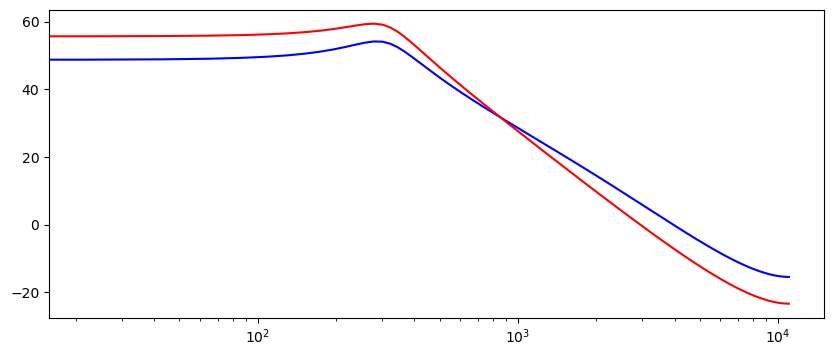

In [73]:
plt.figure(figsize=(10,4))
freqresp = np.empty((framelength//2, nframes), dtype=np.complex128)
w, ref = scipy.signal.freqz([1], glcoeffs[200,:])
plt.plot(w*fs/(2*3.1416), 20. * np.log10(np.abs(ref)), c='blue')
w, ref = scipy.signal.freqz([1/2],new_glcoeffs[200,:]) ### HAY QUE NORMALIZAR LA ENERGIA ?????!!!!
plt.plot(w*fs/(2*3.1416), 20. * np.log10(np.abs(ref)), c='red')
plt.semilogx()
plt.show()

In [80]:
vt_shift = [0 *(2*np.pi)/fs , 0 *(2*np.pi)/fs , 0 *(2*np.pi)/fs ]
new_vt_phase_poles = vt_phase_poles.copy()
for n in range(nframes):
    for s,shift in enumerate(vt_shift):
        new_vt_phase_poles[n,s] = new_vt_phase_poles[n,s]*np.exp(-shift*1j)  # F1

(np.arctan2(new_vt_phase_poles.imag, new_vt_phase_poles.real) * (fs / (2 * np.pi)))[650,:]

array([  505.18251135,   808.49098578,  1261.96543783,  1560.80639929,
        2287.31746008,  2976.82632358,  3414.10168152,  4033.76789259,
        4354.98095741,  4888.12051848,  5241.27618493,  5976.3100895 ,
        6126.77236363,  6549.71780178,  6877.15850547,  7194.72608989,
        8437.47691002,  8793.40743828,  9360.21519366,  9704.61328594,
       10166.9638546 , 10447.56840124])

In [81]:
new_vt_phase_poles.shape

(1286, 22)

In [116]:
new_vt_poles = np.concatenate( (new_vt_phase_poles,
                                     new_vt_phase_poles.conjugate()) , axis=1)

new_vtcoeffs = np.empty((nframes,ncilinders+1))

for n in range(nframes):
    if valid_frame_mask[n]:
        new_vtcoeffs[n,:] = np.poly(new_vt_poles[n,:])
        new_vtcoeffs[n,1] *= 0.2
    else:
        new_vtcoeffs[n,:] = vtcoeffs[n,:]    
    
new_vtcoeffs[650,:], vtcoeffs[650,:]

(array([ 1.        , -0.03317291,  0.05527086,  0.11494318, -0.48797609,
         0.2052779 ,  0.3631698 , -0.38163731,  0.74347682,  0.14617114,
        -0.03242424,  0.37695388,  0.16048303, -0.37659434,  0.60908455,
        -0.54203416,  0.10765288,  0.59651328, -0.18848313,  0.09875977,
         0.548812  , -0.55865508,  0.48747687,  0.04637219, -0.04881402,
         0.16619208,  0.09167511, -0.29190867,  0.40008662, -0.18206488,
        -0.00841758,  0.1643616 , -0.07726357,  0.0289222 ,  0.30559061,
        -0.23370263,  0.18073092, -0.07797933, -0.10170361, -0.00132384,
         0.04845013, -0.03865997,  0.12594931,  0.00363494,  0.05163356]),
 array([ 1.        , -0.16586453,  0.05527086,  0.11494318, -0.48797609,
         0.2052779 ,  0.3631698 , -0.38163731,  0.74347682,  0.14617114,
        -0.03242425,  0.37695387,  0.16048304, -0.37659434,  0.60908453,
        -0.54203414,  0.1076529 ,  0.59651329, -0.18848316,  0.09875963,
         0.54881197, -0.55865473,  0.48747711,  0

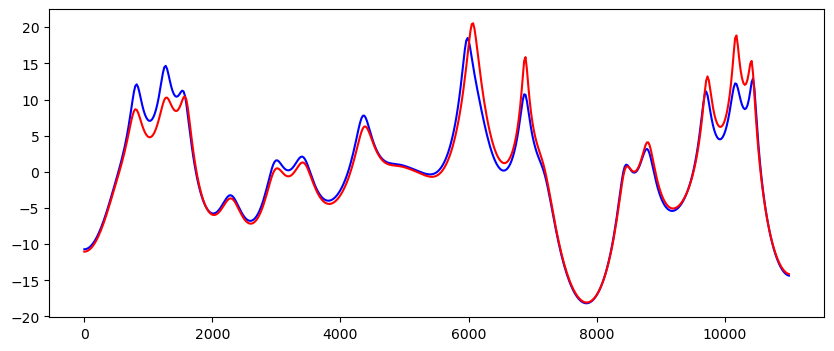

In [117]:
plt.figure(figsize=(10,4))
freqresp = np.empty((framelength//2, nframes), dtype=np.complex128)
w, ref = scipy.signal.freqz([1], vtcoeffs[650,:])
plt.plot(w*fs/(2*3.1416), 20. * np.log10(np.abs(ref)), c='blue')
w, ref = scipy.signal.freqz([1],new_vtcoeffs[650,:]) ### HAY QUE NORMALIZAR LA ENERGIA ?????!!!!
plt.plot(w*fs/(2*3.1416), 20. * np.log10(np.abs(ref)), c='red')
#plt.semilogx()
plt.show()

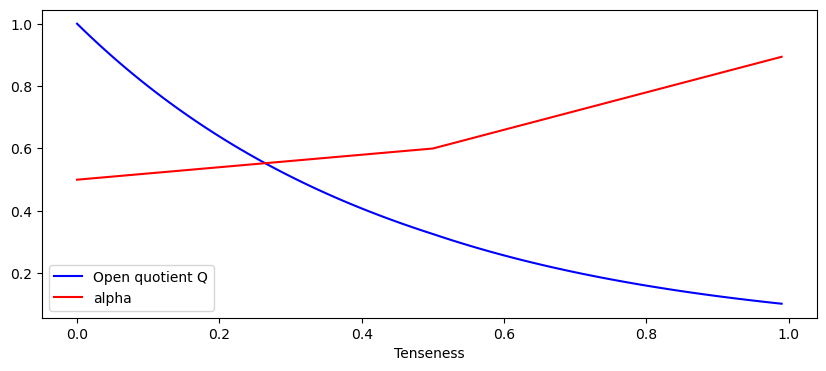

In [155]:
plt.figure(figsize=(10,4))
Ep = 0.9
Qo = 0.9-0.43*Ep
ao = 0.6
Q = []
a = []
for T in np.arange(0,1,0.01):
    if T<= 0.5:
        Q.append( 10**(-2*(1-Qo)*T) )
        a.append( 0.5 + 2*(ao-0.5)*T )
    else:
        Q.append( 10**(2*Qo*(1-T)-1) )
        a.append( 0.9 - 2*(0.9-ao)*(1-T) )
plt.plot(np.arange(0,1,0.01), Q, c='blue', label="Open quotient Q")
plt.plot(np.arange(0,1,0.01), a, c='red', label= "alpha")
plt.xlabel("Tenseness")
plt.legend()
plt.show()

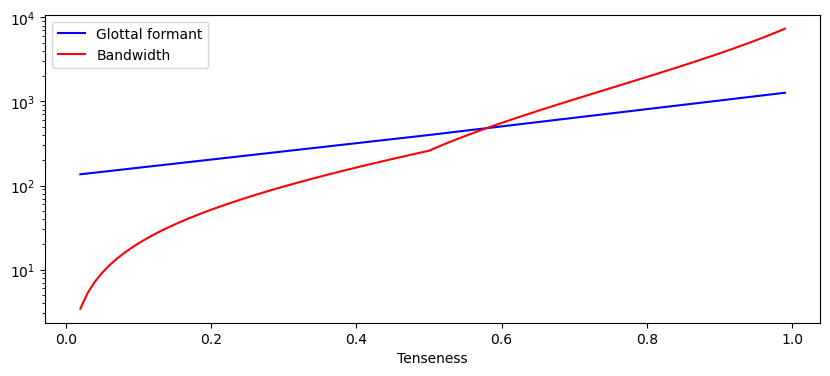

In [148]:
plt.figure(figsize=(10,4))
Ep = 0.9
Qo = 0.9-0.43*Ep
ao = 0.6
Fg = []
Bg = []
rango = np.arange(0.02,1,0.01)
for T in rango:
    if T<= 0.5:
        Q=10**(-2*(1-Qo)*T) 
        a= 0.5 + 2*(ao-0.5)*T 
    else:
        Q= 10**(2*Qo*(1-T)-1) 
        a= 0.9 - 2*(0.9-ao)*(1-T)         
    Fg.append(260/(2*Q))
    Bg.append(260/(Q*np.tan(np.pi*(1-a))))
plt.plot(rango, Fg, c='blue', label="Glottal formant")
plt.plot(rango, Bg, c='red', label= "Bandwidth")
plt.xlabel("Tenseness")
plt.legend()
plt.semilogy()
plt.show()

In [118]:
# now regenerate the audio

In [119]:
# O recomponemos a partir del new vocal tract nada mas...
audio_output = np.zeros_like(audio_input)
for i in range(nframes):  
    frame = glottis_frames[:, i]
    framepad = np.pad(frame, ((0,ncilinders+1)), mode='edge')
    idx = np.arange(librosa.frames_to_samples(i, hop_length=hoplength), librosa.frames_to_samples(i, hop_length=hoplength)+framelength)
    audio_output[idx] += scipy.signal.lfilter([1], new_vtcoeffs[i,:], framepad)[ncilinders+1:] * scipy.signal.get_window("hamming", framelength)

IPython.display.Audio(data=audio_output.T.flatten(), rate=fs,autoplay=True)

In [155]:
# El input, como referencia
IPython.display.Audio(data=audio_input, rate=fs, autoplay=True)

In [32]:
# A la excitacion le hemos sacado primero el vocal tract, y ahora le sacamos la glottis
excitation_frames = librosa.util.frame(excitation_iaif, frame_length=framelength, hop_length=hoplength)
# new glottis
exc_plus_glottis = np.zeros_like(audio_input)
for i in range(nframes):  
    frame = excitation_frames[:, i]
    framepad = np.pad(frame, ((0,ncilinders+1)), mode='edge')
    idx = np.arange(librosa.frames_to_samples(i, hop_length=hoplength), librosa.frames_to_samples(i, hop_length=hoplength)+framelength)
    exc_plus_glottis[idx] += scipy.signal.lfilter([1], new_glcoeffs[i,:], framepad)[ncilinders+1:] * scipy.signal.get_window("hamming", framelength)
# new vocal tract
EG_frames = librosa.util.frame(exc_plus_glottis, frame_length=framelength, hop_length=hoplength)
audio_output = np.zeros_like(audio_input)
for i in range(nframes):  
    frame = EG_frames[:, i]
    framepad = np.pad(frame, ((0,ncilinders+1)), mode='edge')
    idx = np.arange(librosa.frames_to_samples(i, hop_length=hoplength), librosa.frames_to_samples(i, hop_length=hoplength)+framelength)
    audio_output[idx] += scipy.signal.lfilter([1], vtcoeffs[i,:], framepad)[ncilinders+1:] * scipy.signal.get_window("hamming", framelength)


IPython.display.Audio(data=audio_output.T.flatten(), rate=fs,autoplay=True)

In [203]:

lpc_glottis = np.zeros_like(glcoeffs)
for i in range(nframes):
    frame = glottis_frames[:, i]
    lpc_glottis[i,:] = librosa.lpc(frame, order=3)
# LPC Glottis roots
glottis_poles = np.empty((nframes,3),dtype=np.complex128)
glottis_phase_poles = np.empty((nframes,1),dtype=np.complex128)
glottis_real_poles = np.empty((nframes,1),dtype=np.complex128)
glottis_frequencies = np.empty((nframes,1))
glottis_qualityfactor = np.empty((nframes,1))
for n in range(nframes):
    poles = np.roots(lpc_glottis[n,:])
    phase_poles = np.array([r for r in poles if np.imag(r) > 0])
    if phase_poles.shape[0]==1:
        glottis_poles[n,:] = poles       
        glottis_phase_poles[n,:] = phase_poles
        glottis_real_poles[n,:] = np.array([r for r in poles if np.imag(r) == 0])
        glottis_frequencies[n,:] = np.arctan2(phase_poles.imag, phase_poles.real) * (s / (2 * np.pi))
        glottis_qualityfactor[n,:] = np.angle(np.log(phase_poles))
        valid_frame_mask[n] = True
    else:
        valid_frame_mask[n] = False

glottis_formant = glottis_frequencies.mean()

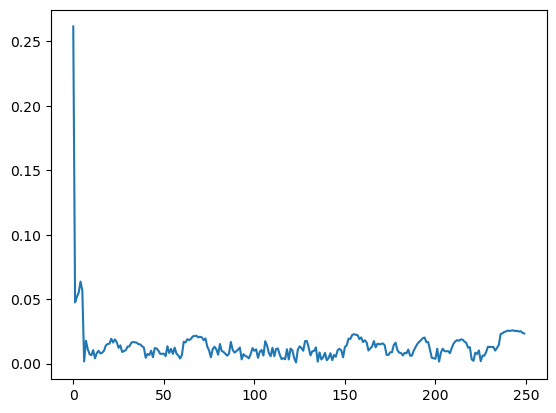

In [210]:
plt.plot(glottis_frequencies[valid_frame_mask>0])
plt.show()

In [211]:
valid_frame_mask.mean()

0.19440124416796267

In [175]:
valid_frame_mask

array([1., 1., 0., ..., 1., 1., 1.])

### Tenseness & Loudness

In [182]:
gframes = librosa.util.frame(glottis_iaif, frame_length=framelength, hop_length=hoplength)

In [183]:
# Rd = torch.tensor((h1h2(gframes, f0, sr=fs) + 7.6) / 11.1)
Rd = np.empty(nframes)
for i in range(nframes):
    X = librosa.amplitude_to_db(np.abs(librosa.stft(gframes[:,i], n_fft=framelength, hop_length=framelength)))
    h1bin = int(np.round(f0[i] / fs * framelength))
    h2bin = int(np.round(2 * f0[i] / fs * framelength))
    Rd[i] = (X[h1bin,1] - X[h2bin,1] + 7.6) / 11.


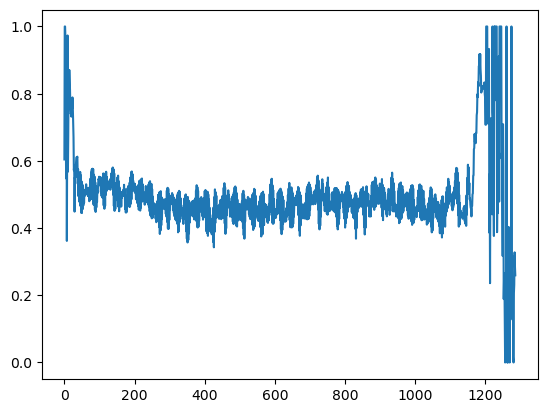

In [187]:
tenseness = np.clip(1 - Rd / 3, 0, 1)
plt.plot(np.arange(nframes), tenseness)
plt.show()

In [189]:
loudness = librosa.feature.rms(y=audio_input, frame_length=framelength, hop_length=hoplength)
#plt.plot(np.arange(nframes), librosa.amplitude_to_db(loudness.T.flatten()))
#plt.show()

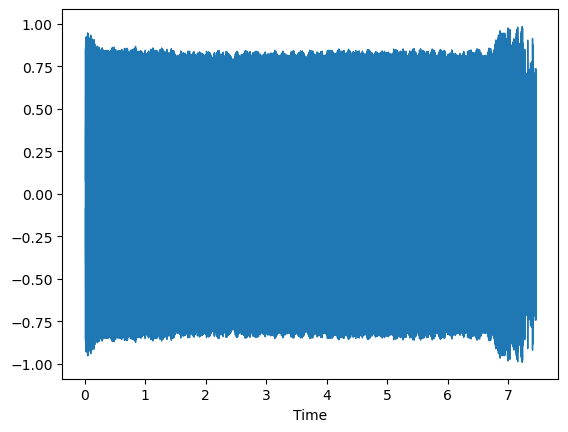

In [190]:
glottis = Glottis(ncilinders, fs)
glottis_signal = glottis.get_waveform(tenseness=torch.Tensor(tenseness), freq=torch.Tensor(f0.reshape(-1, 1)), frame_len=hoplength).detach().numpy()
gframes = librosa.util.frame(glottis_signal, frame_length=framelength, hop_length=hoplength).copy()

librosa.display.waveshow(glottis_signal)
IPython.display.Audio(data=glottis_signal, rate=fs, autoplay=True)

## Curve fitting

In [ ]:
# plot = figure(title="Frequency Response of the Fitted Vocal Tract", width=800, height=400, x_axis_label="Frequency (Hz)", y_axis_label="Magnitude (dB)")

# vt = VocalTractProxy(framelength // 2)

# # damp glottis-lips stationary wave
# vt.r0 = 0.1
# vt.rl = -0.85
# vt.tl = 1 + vt.rl

# vtopt = TractControlsOptimizer(vt)
# Hkl = np.empty((framelength // 2, nframes), dtype=np.complex64)


# # for i in tqdm(range(nframes)):
# for i in tqdm(range(nframes)):
#     target = torch.tensor(freqresp[:,i], dtype=torch.complex64)

#     vtopt.optimize(target, loss_fn=partial(weighted_log_mag_mse_loss, sr=fs), n_iters=20)

#     Hkl[:,i] = vtopt.get_prediction().detach().numpy()

#     plot.line(np.linspace(0, fs // 2, Hkl[:,i].size), librosa.amplitude_to_db(np.abs(freqresp[:,i])), alpha=0.05, color="red")
#     plot.line(np.linspace(0, fs // 2, Hkl[:,i].size), librosa.amplitude_to_db(np.abs(Hkl[:,i])), alpha=0.05)

# show(plot)

In [ ]:
# out = np.zeros_like(input)

# for i in tqdm(range(min(nframes, gframes.shape[1]))):
#     frame = gframes[:, i]
#     framepad = np.pad(frame, ((0,ncilinders+1)), mode='edge')
#     idx = np.arange(librosa.frames_to_samples(i, hop_length=hoplength), librosa.frames_to_samples(i, hop_length=hoplength)+framelength)
#     out[idx] += np.fft.irfft(np.fft.rfft(frame * scipy.signal.get_window("hamming", framelength))[0:-1] * Hkl[:,i], n=framelength)

# out = np.nan_to_num(out, nan=0.0)

# IPython.display.Audio(data=out, rate=fs)

  0%|          | 0/1278 [00:00<?, ?it/s]

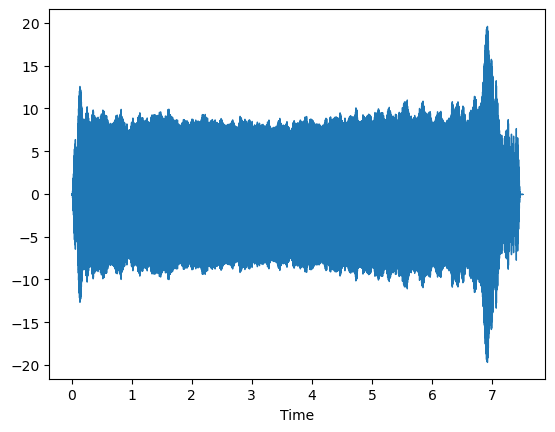

In [198]:
tenseness[:]*=0.1
glottis = Glottis(ncilinders, fs)
glottis_signal = glottis.get_waveform(tenseness=torch.Tensor(tenseness), freq=torch.Tensor(f0.reshape(-1, 1)), frame_len=hoplength).detach().numpy()

gframes = librosa.util.frame(glottis_signal, frame_length=framelength, hop_length=hoplength)

out = np.zeros_like(input)

for i in tqdm(range(min(nframes, gframes.shape[1]))):
    frame = gframes[:, i]
    framepad = np.pad(frame, ((0,ncilinders+1)), mode='edge')
    idx = np.arange(librosa.frames_to_samples(i, hop_length=hoplength), librosa.frames_to_samples(i, hop_length=hoplength)+framelength)
    # out[idx] += np.fft.irfft(np.fft.rfft(frame * scipy.signal.get_window("hamming", framelength))[0:-1] * Hkl[:,i], n=framelength)
    out[idx] += scipy.signal.lfilter([1], vtcoeffs[:,i], framepad)[ncilinders+1:] * scipy.signal.get_window("hamming", framelength)

out = np.nan_to_num(out, nan=0.0)
librosa.display.waveshow(out)

IPython.display.Audio(data=out, rate=fs, autoplay=True)

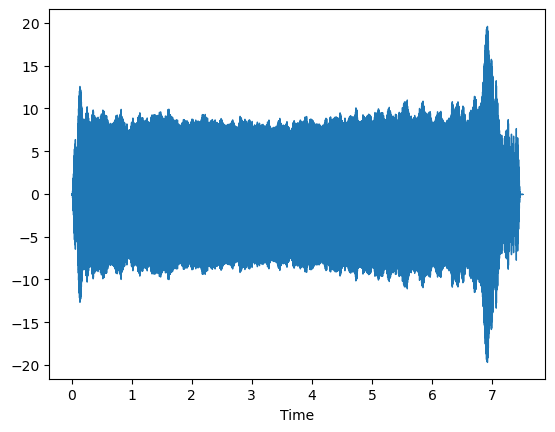

In [199]:
librosa.display.waveshow(out)

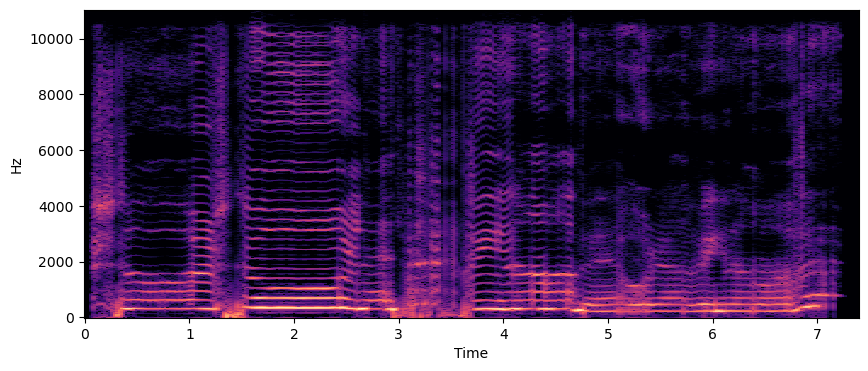

In [30]:
X = librosa.amplitude_to_db(np.abs(librosa.stft(out, n_fft=framelength))).squeeze()
plt.figure(figsize=(10,4))
librosa.display.specshow(X, sr=fs, x_axis="time", y_axis="hz")

In [42]:
F0=0; F4=1000
F1o = 250; F2o = 500; F3o = 750

In [ ]:
dF1 = (F1-F0) / (F2-F0)
dF2 = (F2-F1) / (F3-F1)
dF3 = (F3-F2) / (F4-F2)

F1 = dF1*(F2-F0) + F0           
F2 = dF2*(F3-F1) + F1
F3 = dF3*(F4-F2) + F2

F1 =   dF1   * F2 + F0 * (1-df1)
F2 =   dF2   * F3 + F1 * (1-dF2)
F3 = (1-dF3) * F2 + dF3*F4

F1 =   dF1   * F2 + F0 * (1-df1)  === x = a1*y+a2
F2 =   dF2   * F3 + F1 * (1-dF2)  === y = b1*z+b2*x
F3 = (1-dF3) * F2 + dF3*F4        === z = c2*y+c1

a1 = dF1       a2 = F0*(1-df1)
b1 = dF2       b2 = F1*(1-dF2)
c1 = (1-dF3)   c2 = dF3*F4




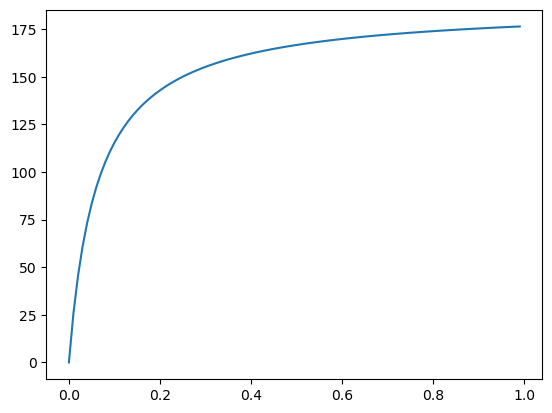

In [57]:
ns = np.arange(0,1,0.01)
F0 = 0; F2 = 500; F3 = 750; F4= 1000
def F1(dF1, dF2, dF3):
    x = ( dF1*dF2*dF3*F4/ (1 - dF2 - dF2*dF3 )  + F0 * (1-dF1) ) / ( ( 1 + dF1 - dF2 - dF2*dF3  + dF1*dF2 )/ (1 - dF2 - dF2*dF3 ) )
    return x
plt.plot( ns, [F1(x,0.6,0.5) for x in ns] )